In [1]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="efficientnet-b0",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=3,                      # model output channels (number of classes in your dataset)
)

In [2]:
# Unet ++ 나중에 하긋ㅂ
model = smp.UnetPlusPlus(
    encoder_name="efficientnet-b0",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=3,                      # model output channels (number of classes in your dataset)
)

In [3]:
import os
os.listdir('../../../../Datasets/NewSkinDataset/original')

['val', '.ipynb_checkpoints', 'train']

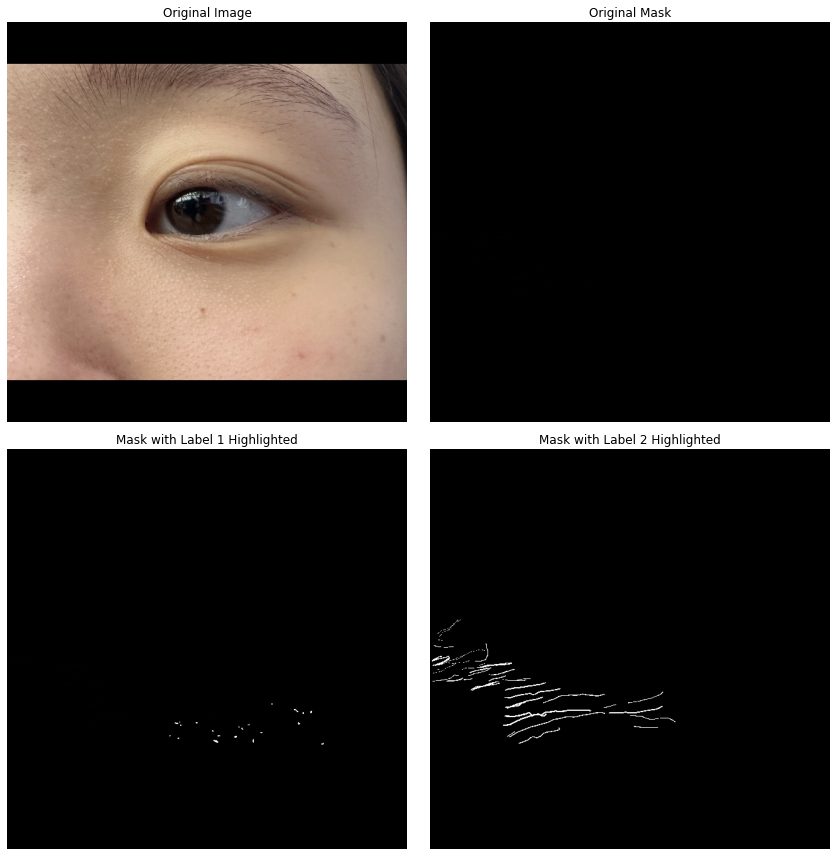

In [4]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# 이미지와 마스크 경로 설정
image_path = os.path.join('../../../../Datasets/NewSkinDataset/original/train/images', os.listdir('../../../../Datasets/NewSkinDataset/original/train/images')[0])
mask_path = os.path.join('../../../../Datasets/NewSkinDataset/original/train/masks', os.listdir('../../../../Datasets/NewSkinDataset/original/train/masks')[0])

# 이미지와 마스크 열기
image = Image.open(image_path)
mask = Image.open(mask_path)

# 마스크를 numpy 배열로 변환
mask_np = np.array(mask)

# 라벨 1에 해당하는 값 (1, 1, 1)을 (255, 255, 255)로 변경
mask_label1 = mask_np.copy()
mask_label1[(mask_np[:,:,0] == 1) & (mask_np[:,:,1] == 1) & (mask_np[:,:,2] == 1)] = [255, 255, 255]

# 라벨 2에 해당하는 값 (2, 2, 2)을 (255, 255, 255)로 변경
mask_label2 = mask_np.copy()
mask_label2[(mask_np[:,:,0] == 2) & (mask_np[:,:,1] == 2) & (mask_np[:,:,2] == 2)] = [255, 255, 255]

# 이미지와 마스크들 시각화
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# 첫 번째 줄: 원본 이미지, 원본 마스크
axes[0, 0].imshow(image)
axes[0, 0].set_title('Original Image')
axes[0, 0].axis('off')

axes[0, 1].imshow(mask)
axes[0, 1].set_title('Original Mask')
axes[0, 1].axis('off')

# 두 번째 줄: 라벨 1, 2 강조 마스크
axes[1, 0].imshow(mask_label1)
axes[1, 0].set_title('Mask with Label 1 Highlighted')
axes[1, 0].axis('off')

axes[1, 1].imshow(mask_label2)
axes[1, 1].set_title('Mask with Label 2 Highlighted')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()


In [5]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import segmentation_models_pytorch as smp

class SkinDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir, 'images')
        self.mask_dir = os.path.join(root_dir, 'masks')
        
        # Add a filter to exclude directories
        self.image_files = sorted([f for f in os.listdir(self.image_dir) if os.path.isfile(os.path.join(self.image_dir, f))])
        self.mask_files = sorted([f for f in os.listdir(self.mask_dir) if os.path.isfile(os.path.join(self.mask_dir, f))])
        
        self.transform = transform
        
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        
        
        image = transforms.ToTensor()(image)
        mask = transforms.ToTensor()(mask)
        mask = (mask * 255).to(torch.uint8)
        return image, mask
    
        
transform = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor()
])

train_data = SkinDataset(root_dir='../../../../Datasets/NewSkinDataset/original/train', transform=transform)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

for images, masks in train_loader:
    print(images.shape, masks.shape)
    break


torch.Size([32, 3, 640, 640]) torch.Size([32, 1, 640, 640])


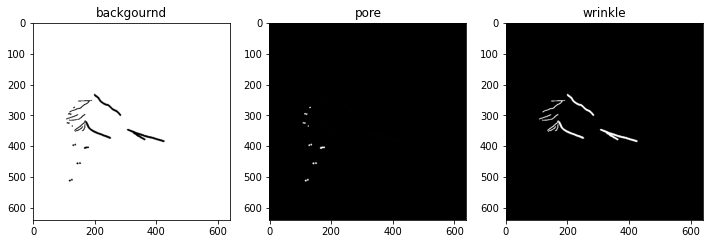

In [6]:
import matplotlib.pyplot as plt


# 0, 1, 2 값을 가진 부분을 서로 다른 서브플롯에 시각화
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(12, 4))

# 원래 이미지
img = masks[0].clone().cpu().numpy()
img = img.squeeze()

img[img == 0] = 255
ax0.imshow(img, cmap='gray')
ax0.set_title('backgournd')

img = masks[0].clone().cpu().numpy()
img = img.squeeze()

img[img == 1] = 255
ax1.imshow(img, cmap='gray')
ax1.set_title('pore')

img = masks[0].clone().cpu().numpy()
img = img.squeeze()

img[img == 2] = 255
ax2.imshow(img, cmap='gray')
ax2.set_title('wrinkle')

plt.show()


In [7]:
img = masks[0].clone().cpu().numpy()
img = img.squeeze()
import numpy as np

# Assuming img is your NumPy array
unique_values, value_counts = np.unique(img, return_counts=True)

# Print the unique values and their respective counts
for value, count in zip(unique_values, value_counts):
    print(f"Value: {value}, Count: {count}")


Value: 0, Count: 405917
Value: 1, Count: 368
Value: 2, Count: 3315


In [8]:
model = smp.Unet(
    encoder_name="efficientnet-b0",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
)

In [9]:
output = model(images)
print(output.shape)


torch.Size([32, 1, 640, 640])


In [ ]:
self.train_mean_iou.add_batch(predictions=preds.detach().cpu().numpy(), 
                              references=y.detach().cpu().numpy())
miou = self.train_mean_iou.compute(num_labels=3, ignore_index=255)
background_miou = miou['per_category_iou'][0]
pore_miou = miou['per_category_iou'][1]
wrinkle_miou = miou['per_category_iou'][2]

total_miou = (background_miou + pore_miou + wrinkle_miou) / 3

self.log('train_background_miou', background_miou, on_step=True, on_epoch=True, prog_bar=True, logger=True)
self.log('train_pore_miou', pore_miou, on_step=True, on_epoch=True, prog_bar=True, logger=True)
self.log('train_wrinkle_miou', wrinkle_miou, on_step=True, on_epoch=True, prog_bar=True, logger=True)
self.log('train_wrinkle_miou', wrinkle_miou, on_step=True, on_epoch=True, prog_bar=True, logger=True)

total_miou = (background_miou + pore_miou + wrinkle_miou) / 3
self.log('train_miou', total_miou, on_step=True, on_epoch=True, prog_bar=True, logger=True)


### model training 

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import segmentation_models_pytorch as smp

class SkinDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir, 'images')
        self.mask_dir = os.path.join(root_dir, 'masks')
        
        # Add a filter to exclude directories
        self.image_files = sorted([f for f in os.listdir(self.image_dir) if os.path.isfile(os.path.join(self.image_dir, f))])
        self.mask_files = sorted([f for f in os.listdir(self.mask_dir) if os.path.isfile(os.path.join(self.mask_dir, f))])
        
        self.transform = transform
        
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        
        
        image = transforms.ToTensor()(image)
        mask = transforms.ToTensor()(mask)
        mask = (mask * 255).to(torch.uint8)
        return image, mask

### todo
step 부분에 evalute metirc과 loss를 부분을 분리  
loss를 crossentropy로 변경  

In [8]:
import torch
import torch.nn.functional as F
from torch import nn
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
from datasets import load_metric
from torchvision import transforms
from PIL import Image
import pandas as pd



class LitEfficientNet(pl.LightningModule):
    def __init__(self, train_dataloader=None, val_dataloader=None, test_dataloader=None, batch_size=32):
        super(LitEfficientNet, self).__init__()
        self.train_data_loader = train_dataloader
        self.val_data_loader = val_dataloader
        self.test_data_loader = test_dataloader
        self.model = smp.Unet(
            encoder_name="efficientnet-b0", 
            encoder_weights="imagenet", 
            in_channels=3, 
            classes=3
        )
        self.criterion = nn.CrossEntropyLoss()
        self.train_mean_iou = load_metric("mean_iou")
        self.val_mean_iou = load_metric("mean_iou")
        self.test_mean_iou = load_metric("mean_iou")
        self.batch_size = batch_size

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)

        preds = preds.float()
        y = y.squeeze(1).long()

        loss = self.criterion(preds, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        preds_labels = torch.argmax(preds, dim=1).detach().cpu().numpy()
        y_true = y.detach().cpu().numpy()

        miou = self.val_mean_iou.compute(predictions=preds_labels.tolist(), 
                                         references=y_true.tolist(), 
                                         num_labels=3,
                                         ignore_index=255)['per_category_iou']
        miou_values = {
            'background_miou': miou[0],
            'pore_miou': miou[1],
            'wrinkle_miou': miou[2]
        }

        self.log('train_background_miou', miou[0], on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_pore_miou', miou[1], on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_wrinkle_miou', miou[2], on_step=True, on_epoch=True, prog_bar=True, logger=True)

        return {'loss' : loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)

        preds = preds.float()
        y = y.squeeze(1).long()

        loss = self.criterion(preds, y)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        preds_labels = torch.argmax(preds, dim=1).detach().cpu().numpy()
        y_true = y.detach().cpu().numpy()

        miou = self.val_mean_iou.compute(predictions=preds_labels.tolist(), 
                                         references=y_true.tolist(), 
                                         num_labels=3,
                                         ignore_index=255)['per_category_iou']
        miou_values = {
            'background_miou': miou[0],
            'pore_miou': miou[1],
            'wrinkle_miou': miou[2]
        }

        self.log('val_background_miou', miou[0], on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_pore_miou', miou[1], on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_wrinkle_miou', miou[2], on_step=True, on_epoch=True, prog_bar=True, logger=True)

        return {'val_loss' : loss}
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)

        preds = preds.float()
        y = y.squeeze(1).long()

        loss = self.criterion(preds, y)
        self.log('test_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        preds_labels = torch.argmax(preds, dim=1).detach().cpu().numpy()
        y_true = y.detach().cpu().numpy()

        miou = self.val_mean_iou.compute(predictions=preds_labels.tolist(), 
                                         references=y_true.tolist(), 
                                         num_labels=3,
                                         ignore_index=255)['per_category_iou']
        miou_values = {
            'background_miou': miou[0],
            'pore_miou': miou[1],
            'wrinkle_miou': miou[2]
        }

        self.log('test_background_miou', miou[0], on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('test_pore_miou', miou[1], on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('test_wrinkle_miou', miou[2], on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return {'test_loss' : loss}

    
    def configure_optimizers(self):
        return torch.optim.Adam([p for p in self.parameters() if p.requires_grad], lr=1e-08, eps=1e-08)
    
    def train_dataloader(self):
        return self.train_data_loader
    
    def val_dataloader(self):
        return self.val_data_loader
    
    def test_dataloader(self):
        return self.test_data_loader


In [9]:
batch_size = 2
transform = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.ToTensor()
])
train_data = SkinDataset(root_dir='../../../../Datasets/NewSkinDataset/original/train', transform=transform)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

test_data = SkinDataset(root_dir='../../../../Datasets/NewSkinDataset/original/val', transform=transform)
test_loader = DataLoader(test_data, batch_size=10, shuffle=True)


In [10]:
for images, masks in train_loader:
    print(images.shape, masks.shape)
    break


torch.Size([2, 3, 640, 640]) torch.Size([2, 1, 640, 640])


In [11]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint


In [13]:
checkpoint_callback = ModelCheckpoint(save_top_k=1, monitor="val_loss")
early_stop_callback = EarlyStopping(
    monitor="val_loss", 
    min_delta=0.00, 
    patience=3, 
    verbose=False, 
    mode="min",
)

model = LitEfficientNet(train_dataloader=train_loader ,
                        val_dataloader=test_loader,
                        test_dataloader=test_loader,
                        )

pl.seed_everything(42)
trainer = pl.Trainer(max_epochs=500,
                     callbacks=[early_stop_callback, checkpoint_callback],
                     gpus=[1])
trainer.fit(model)
trainer.save_checkpoint('./model_pt/2023_09_08_init_test.ckpt')

Global seed set to 42
/home/nplab/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=[1])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[1])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /home/nplab/NPLAB-NAS/Members/SEO/skin-type/segmentation_models/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Unet             | 6.3 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
6.3 M     Trainable params
0         Non-trainable params
6.3 M     Total params
25.007    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/nplab/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/home/nplab/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/nplab/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus 

Training: 0it [00:00, ?it/s]

/home/nplab/.cache/huggingface/modules/datasets_modules/metrics/mean_iou/61639d20a0ab999a51605e4c733e59f0bc3056966c5c6a5302f281301e73eefa/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
# save and load 
model = LitEfficientNet.load_from_checkpoint(checkpoint_path='./model_pt/2023_09_08_init_test.ckpt')
trainer.save_checkpoint('./model_pt/2023_09_08_init_test.ckpt')